# Group Details

## Group Name: 12

### Student 1: Denise La Gordt Dillie

### Student 2: Andreea Maican

### Student 3: Sambhav Jain

# Loading Data and Preliminaries

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from torch_geometric.data import Data
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import os
import math
import random
import time
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm import tqdm

c:\.virtualenvs\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")

In [3]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""

example = load_array('C:/Users/Gebruiker/OneDrive - TU Eindhoven/TUe/Master/2AMM10/tue-deeplearning/assignments/assignment_2/data/task 1/train/trajectory_0.npz', task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(initial_state)
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
[[ 4.54673709 -5.27118739  5.07863417 -1.09690628 -3.66929964]
 [ 3.57509525  4.3270607  -0.08095022 -0.57868726 -2.95971243]
 [ 2.67733735 -5.15972108  5.35238208  2.42652043  1.45870728]
 [ 2.27455417 -6.79584511  2.29632123  0.30418238 -0.4065998 ]
 [ 2.38359341 -2.75861066  1.77940931 -0.07643627 -0.35954359]
 [ 4.28596268  0.34981219  4.8286224   1.35630962 -2.55760522]
 [ 3.03118516 -0.50562258 15.04631712 -0.94772523 14.98127867]
 [ 4.13530017  1.81342682  3.84375499 -0.6989711  -2.25092411]]
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [4]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time. 
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example = load_array('C:/Users/Gebruiker/OneDrive - TU Eindhoven/TUe/Master/2AMM10/tue-deeplearning/assignments/assignment_2/data/task 2_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_array('C:/Users/Gebruiker/OneDrive - TU Eindhoven/TUe/Master/2AMM10/tue-deeplearning/assignments/assignment_2/data/task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


In [5]:
test_initial_state

array([[ 4.31455329, -4.99311363, -5.10150489,  2.2491171 , -1.82520359],
       [ 2.58525749, -4.92574075, -4.7534334 , -4.81897728, -3.07212095],
       [ 2.40449047,  2.23254187, -6.04595524, -0.67381217, -0.58798851],
       [ 2.28318603,  5.6605113 , -3.76376281, -0.41268251, -1.19812499],
       [ 4.09793595, -4.73678906, -3.94704856,  1.13634781,  4.98383634],
       [ 4.5579536 , -0.08848969,  5.42483477,  1.460317  , -0.21585929],
       [ 3.42356878, -4.91282501, -4.6779343 ,  0.94123905,  2.66425652],
       [ 3.59288181, -4.48225046, -4.548729  , -2.56573061, -2.39203918]])

# Data Handling and Preprocessing

In [6]:
def create_graph_data(initial_state, terminal_state):
    '''Takes a datapoint from task 1 data and returns a Data object ready to be used with
    Pytorch Geometric. Each node is an object and will store initial position and speed, each edge stores
    the distance between two objects and also their masses.'''
    initial_state = np.array(initial_state)
    terminal_state = np.array(terminal_state)

    n_bodies = initial_state.shape[0]
    num_features = initial_state.shape[1]

    # Create node features tensor
    node_features = torch.tensor(initial_state, dtype=torch.float)
    node_features = node_features.view(-1, num_features)  # Reshape to (num_nodes, num_features)

    # Create edge index tensor
    edge_index = torch.tensor([[i, j] for i in range(n_bodies) for j in range(n_bodies) if (i != j and i<j)], dtype=torch.long)
    edge_index = edge_index.t().contiguous()  # Reshape to (2, num_edges)

    # Create edge features tensor
    num_edges = edge_index.size(1)
    edge_features = torch.empty(num_edges, 1, dtype=torch.float)
    # Populate edge features with force
    for k, (i, j) in enumerate(edge_index.t()):
        dx = node_features[i, 1] - node_features[j, 1]
        dy = node_features[i, 2] - node_features[j, 2]
        distance = torch.sqrt(dx**2 + dy**2)
        force = ((node_features[i,0]*node_features[j,0])/(distance**2 + 1e-8))
        edge_features[k] = force

    # Create target tensor
    target = torch.tensor(terminal_state, dtype=torch.float).view(-1, 2)  # Reshape to (num_nodes, num_features + 1)

    # Create PyG Data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=target)

    return data

# Example usage
initial_state = [[1.0, 0.5, 0.3, 0.2, 0.1], [2.0, 0.1, 0.4, 0.3, 0.2], [0.5, 0.7, 0.8, 0.9, 1.0]]
terminal_state = [[0.3, 0.2], [0.4, 0.6], [0.8, 0.9]]

graph_data = create_graph_data(initial_state, terminal_state)
print(graph_data.x, graph_data.edge_index, graph_data.edge_attr, graph_data.y)

tensor([[1.0000, 0.5000, 0.3000, 0.2000, 0.1000],
        [2.0000, 0.1000, 0.4000, 0.3000, 0.2000],
        [0.5000, 0.7000, 0.8000, 0.9000, 1.0000]]) tensor([[0, 0, 1],
        [1, 2, 2]]) tensor([[11.7647],
        [ 1.7241],
        [ 1.9231]]) tensor([[0.3000, 0.2000],
        [0.4000, 0.6000],
        [0.8000, 0.9000]])


In [45]:
def create_graph_data_symm(initial_state, terminal_state):
    initial_state = np.array(initial_state)
    terminal_state = np.array(terminal_state)

    n_bodies = initial_state.shape[0]
    num_features = initial_state.shape[1]

    # Calculate center of mass
    total_mass = np.sum(initial_state[:, 0])
    center_of_mass_x = np.sum(initial_state[:, 1] * initial_state[:, 0]) / total_mass
    center_of_mass_y = np.sum(initial_state[:, 2] * initial_state[:, 0]) / total_mass

    # Adjust positions relative to center of mass for initial and terminal states
    initial_state[:, 1] -= center_of_mass_x
    initial_state[:, 2] -= center_of_mass_y
    
    terminal_state[:, 0] -= center_of_mass_x
    terminal_state[:, 1] -= center_of_mass_y
    
    # Find the indices of the two most massive objects
    mass_indices = np.argsort(initial_state[:, 0])
    indices = mass_indices[-2:]
    
    # Calculate the vector between the two most massive objects
    vector = initial_state[indices[1], 1:3] - initial_state[indices[0], 1:3]
    
    # Calculate the angle of rotation based on the vector
    angle = math.atan2(vector[1], vector[0])
    
    # Apply rotation to the positions
    rot_matrix = np.array([[math.cos(-angle), -math.sin(-angle)], [math.sin(-angle), math.cos(-angle)]])
    initial_state[:, 1:3] = np.matmul(rot_matrix, initial_state[:, 1:3].T).T
    terminal_state = np.matmul(rot_matrix, terminal_state.T).T
    
    # Create node features tensor
    node_features = torch.tensor(initial_state, dtype=torch.float)
    node_features = node_features.view(-1, num_features)  # Reshape to (num_nodes, num_features)

    # Create edge index tensor
    edge_index = torch.tensor([[i, j] for i in range(n_bodies) for j in range(n_bodies) if (i != j and i<j)], dtype=torch.long)
    edge_index = edge_index.t().contiguous()  # Reshape to (2, num_edges)

    # Create edge features tensor
    num_edges = edge_index.size(1)
    edge_features = torch.empty(num_edges, 1, dtype=torch.float)
    # Populate edge features with force
    for k, (i, j) in enumerate(edge_index.t()):
        dx = node_features[i, 1] - node_features[j, 1]
        dy = node_features[i, 2] - node_features[j, 2]
        distance = torch.sqrt(dx**2 + dy**2)
        force = ((node_features[i,0]*node_features[j,0])/(distance**2 + 1e-8))
        edge_features[k] = force

    # Create target tensor
    target = torch.tensor(terminal_state, dtype=torch.float).view(-1, 2)  # Reshape to (num_nodes, num_features + 1)

    # Create PyG Data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=target)

    return data

# Example usage
initial_state = [[1.0, 0.5, 0.3, 0.2, 0.1], [2.0, 0.1, 0.4, 0.3, 0.2], [0.5, 0.7, 0.8, 0.9, 1.0]]
terminal_state = [[0.3, 0.2], [0.4, 0.6], [0.8, 0.9]]

graph_data = create_graph_data_symm(initial_state, terminal_state)
print(graph_data.x, graph_data.edge_index, graph_data.edge_attr, graph_data.y)

tensor([[ 1.0000, -0.2252,  0.0762,  0.2000,  0.1000],
        [ 2.0000,  0.1871,  0.0762,  0.3000,  0.2000],
        [ 0.5000, -0.2980, -0.4574,  0.9000,  1.0000]]) tensor([[0, 0, 1],
        [1, 2, 2]]) tensor([[11.7647],
        [ 1.7241],
        [ 1.9231]]) tensor([[-0.0554,  0.2217],
        [-0.0554, -0.1906],
        [-0.3707, -0.5786]])


In [46]:
def create_dataloader(data_folder, task, shuffle, batch_size, train_ratio=0.8):
    data_list = []  # List to store the Data objects

    # Loop over all files in the folder
    for filename in os.listdir(data_folder):
        file_path = os.path.join(data_folder, filename)

        # Read the data from the file (modify this part based on your file format)
        states = load_array(file_path, task=task)
        initial_state, terminal_state = states

        # Create the Data object using create_graph_data function
        data = create_graph_data_symm(initial_state, terminal_state)

        # Append the Data object to the list
        data_list.append(data)

    # Shuffle the data if specified
    if shuffle:
        random.shuffle(data_list)

    # Calculate the number of samples
    num_samples = len(data_list)

    if "train" in data_folder:
        # Calculate the number of samples for train and validation
        num_train = int(train_ratio * num_samples)
        num_val = num_samples - num_train

        # Split the data into train and validation sets
        train_data = data_list[:num_train]
        val_data = data_list[num_train:]

        # Print the number of data samples
        print(f"Number of data samples in {data_folder}: {num_samples}")
        print(f"Number of training samples: {num_train}")
        print(f"Number of validation samples: {num_val}")

        # Create data loaders for train and validation sets
        dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        dataloader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        return dataloader_train, dataloader_val, data_list
    else:
        # Print the number of data samples
        print(f"Number of data samples in {data_folder}: {num_samples}")

        # Create a data loader for the data
        dataloader = DataLoader(data_list, batch_size=batch_size, shuffle=shuffle)

        return dataloader, data_list

# Specify the paths to your train and test data folders
data_folder_train = 'C:/Users/Gebruiker/OneDrive - TU Eindhoven/TUe/Master/2AMM10/tue-deeplearning/assignments/assignment_2/data/task 1/train'
data_folder_test = 'C:/Users/Gebruiker/OneDrive - TU Eindhoven/TUe/Master/2AMM10/tue-deeplearning/assignments/assignment_2/data/task 1/test'

# Define the batch size
batch_size = 50

# Create data loaders for train and validation sets (only if the folder contains "train")
dataloader_train, dataloader_val, data_list = create_dataloader(data_folder_train, task='task 1', shuffle=True, batch_size=batch_size)

# Create a separate data loader for the test set
dataloader_test, data_list_test = create_dataloader(data_folder_test, task='task 1', shuffle=False, batch_size=batch_size)

Number of data samples in C:/Users/Gebruiker/OneDrive - TU Eindhoven/TUe/Master/2AMM10/tue-deeplearning/assignments/assignment_2/data/task 1/train: 900
Number of training samples: 720
Number of validation samples: 180
Number of data samples in C:/Users/Gebruiker/OneDrive - TU Eindhoven/TUe/Master/2AMM10/tue-deeplearning/assignments/assignment_2/data/task 1/test: 100


# Task 1

# Model Implementation

In [96]:
from torch_geometric.nn import SAGEConv

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()

        self.conv1 = SAGEConv(5, 64)
        self.conv2 = SAGEConv(64, 128)
        self.conv3 = SAGEConv(128, 256)
        self.conv4 = SAGEConv(256, 512)
        self.conv5 = SAGEConv(512, 256)
        self.conv6 = SAGEConv(256, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = self.conv6(x, edge_index)

        return x

# Model Training

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print(f'Loaded device: {device}')

Loaded device: cpu


In [98]:
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = torch.nn.MSELoss()

def train(loader):
    model.train()
    total_loss = 0
    total_r2_score = 0
    total_mae = 0
    total_samples = 0

    for data in loader:
        data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predictions = output.detach().cpu().numpy()
        true_labels = data.y.detach().cpu().numpy()
        batch_size = true_labels.shape[0]
        total_samples += batch_size

         # R2 Score
        total_r2_score += r2_score(true_labels, predictions) * batch_size

        # MAE
        mae = mean_absolute_error(true_labels, predictions)
        total_mae += mae * batch_size

    avg_loss = total_loss / len(loader)
    avg_r2_score = total_r2_score / total_samples
    avg_mae = total_mae / total_samples

    return avg_loss, avg_r2_score, avg_mae

def evaluate(loader):
    model.eval()
    total_loss = 0
    total_r2_score = 0
    total_mae = 0
    total_samples = 0

    with torch.no_grad():
        for data in loader:
            data.to(device)
            output = model(data)
            loss = loss_func(output, data.y)
            total_loss += loss.item()

            predictions = output.detach().cpu().numpy()
            true_labels = data.y.detach().cpu().numpy()
            batch_size = true_labels.shape[0]
            total_samples += batch_size

            # R2 Score
            total_r2_score += r2_score(true_labels, predictions) * batch_size

            # MAE
            mae = mean_absolute_error(true_labels, predictions)
            total_mae += mae * batch_size

    avg_loss = total_loss / len(loader)
    avg_r2_score = total_r2_score / total_samples
    avg_mae = total_mae / total_samples

    return avg_loss, avg_r2_score, avg_mae

In [99]:
epochs = 50
start = time.time()

train_losses, train_r2_scores, train_maes = [], [], []
val_losses, val_r2_scores, val_maes = [], [], []
test_losses, test_r2_scores, test_maes = [], [], []

for epoch in tqdm(range(1, epochs + 1)):

    train_loss, train_r2_score, train_mae = train(dataloader_train)
    val_loss, val_r2_score, val_mae = evaluate(dataloader_val)
    test_loss, test_r2_score, test_mae = evaluate(dataloader_test)

    toc = time.time()
    print(f'EPOCH: {epoch:03d}, TRAIN LOSS: {train_loss:.4f}, VAL LOSS: {val_loss:.4f}, TEST LOSS: {test_loss:.4f}. TRAINING TIME SO FAR: {toc - start:.1f} s\n'
          f'TRAIN R2: {train_r2_score:.4f}, VAL R2: {val_r2_score:.4f}, TEST R2: {test_r2_score:.4f}\n'
          f'TRAIN MAE: {train_mae:.4f}, VAL MAE: {val_mae:.4f}, TEST MAE: {test_mae:.4f}\n')

    # Store metrics
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)
    train_maes.append(train_mae)

    val_losses.append(val_loss)
    val_r2_scores.append(val_r2_score)
    val_maes.append(val_mae)

    test_losses.append(test_loss)
    test_r2_scores.append(test_r2_score)
    test_maes.append(test_mae)

  2%|▏         | 1/50 [00:02<02:03,  2.52s/it]

EPOCH: 001, TRAIN LOSS: 12.0884, VAL LOSS: 8.3703, TEST LOSS: 6.4876. TRAINING TIME SO FAR: 2.5 s
TRAIN R2: 0.3815, VAL R2: 0.5555, TEST R2: 0.6397
TRAIN MAE: 2.6275, VAL MAE: 2.1821, TEST MAE: 1.9979



  4%|▍         | 2/50 [00:04<01:45,  2.19s/it]

EPOCH: 002, TRAIN LOSS: 8.0331, VAL LOSS: 7.4293, TEST LOSS: 5.6982. TRAINING TIME SO FAR: 4.5 s
TRAIN R2: 0.5939, VAL R2: 0.6053, TEST R2: 0.6808
TRAIN MAE: 2.0831, VAL MAE: 2.0153, TEST MAE: 1.8525



  6%|▌         | 3/50 [00:06<01:38,  2.09s/it]

EPOCH: 003, TRAIN LOSS: 7.3851, VAL LOSS: 7.2606, TEST LOSS: 5.4930. TRAINING TIME SO FAR: 6.5 s
TRAIN R2: 0.6256, VAL R2: 0.6125, TEST R2: 0.6906
TRAIN MAE: 2.0037, VAL MAE: 1.9850, TEST MAE: 1.8092



  8%|▊         | 4/50 [00:08<01:40,  2.18s/it]

EPOCH: 004, TRAIN LOSS: 7.3045, VAL LOSS: 7.1586, TEST LOSS: 5.5012. TRAINING TIME SO FAR: 8.8 s
TRAIN R2: 0.6282, VAL R2: 0.6185, TEST R2: 0.6930
TRAIN MAE: 1.9913, VAL MAE: 1.9725, TEST MAE: 1.8216



 10%|█         | 5/50 [00:10<01:34,  2.10s/it]

EPOCH: 005, TRAIN LOSS: 7.0686, VAL LOSS: 7.0637, TEST LOSS: 5.2975. TRAINING TIME SO FAR: 10.7 s
TRAIN R2: 0.6312, VAL R2: 0.6235, TEST R2: 0.7030
TRAIN MAE: 1.9806, VAL MAE: 1.9498, TEST MAE: 1.7711



 12%|█▏        | 6/50 [00:12<01:28,  2.02s/it]

EPOCH: 006, TRAIN LOSS: 6.8416, VAL LOSS: 7.5061, TEST LOSS: 5.6119. TRAINING TIME SO FAR: 12.6 s
TRAIN R2: 0.6445, VAL R2: 0.5969, TEST R2: 0.6843
TRAIN MAE: 1.9479, VAL MAE: 2.0520, TEST MAE: 1.8545



 14%|█▍        | 7/50 [00:14<01:27,  2.04s/it]

EPOCH: 007, TRAIN LOSS: 6.6342, VAL LOSS: 7.2929, TEST LOSS: 5.5496. TRAINING TIME SO FAR: 14.7 s
TRAIN R2: 0.6522, VAL R2: 0.6125, TEST R2: 0.6924
TRAIN MAE: 1.9447, VAL MAE: 1.9887, TEST MAE: 1.8193



 16%|█▌        | 8/50 [00:17<01:34,  2.25s/it]

EPOCH: 008, TRAIN LOSS: 6.6678, VAL LOSS: 7.2246, TEST LOSS: 5.3983. TRAINING TIME SO FAR: 17.4 s
TRAIN R2: 0.6585, VAL R2: 0.6126, TEST R2: 0.6970
TRAIN MAE: 1.9220, VAL MAE: 1.9743, TEST MAE: 1.7816



 18%|█▊        | 9/50 [00:19<01:28,  2.16s/it]

EPOCH: 009, TRAIN LOSS: 6.8788, VAL LOSS: 7.1021, TEST LOSS: 5.3425. TRAINING TIME SO FAR: 19.3 s
TRAIN R2: 0.6567, VAL R2: 0.6220, TEST R2: 0.7018
TRAIN MAE: 1.8844, VAL MAE: 1.9728, TEST MAE: 1.7848



 20%|██        | 10/50 [00:21<01:28,  2.21s/it]

EPOCH: 010, TRAIN LOSS: 6.6024, VAL LOSS: 6.9322, TEST LOSS: 5.1579. TRAINING TIME SO FAR: 21.7 s
TRAIN R2: 0.6689, VAL R2: 0.6303, TEST R2: 0.7128
TRAIN MAE: 1.8566, VAL MAE: 1.9336, TEST MAE: 1.7441



 22%|██▏       | 11/50 [00:23<01:20,  2.07s/it]

EPOCH: 011, TRAIN LOSS: 6.1927, VAL LOSS: 7.0261, TEST LOSS: 5.2246. TRAINING TIME SO FAR: 23.4 s
TRAIN R2: 0.6850, VAL R2: 0.6257, TEST R2: 0.7088
TRAIN MAE: 1.8216, VAL MAE: 1.9281, TEST MAE: 1.7303



 24%|██▍       | 12/50 [00:25<01:22,  2.16s/it]

EPOCH: 012, TRAIN LOSS: 6.0653, VAL LOSS: 7.2035, TEST LOSS: 5.6779. TRAINING TIME SO FAR: 25.8 s
TRAIN R2: 0.6858, VAL R2: 0.6153, TEST R2: 0.6844
TRAIN MAE: 1.8338, VAL MAE: 1.9828, TEST MAE: 1.8213



 26%|██▌       | 13/50 [00:27<01:19,  2.15s/it]

EPOCH: 013, TRAIN LOSS: 5.7630, VAL LOSS: 7.0654, TEST LOSS: 5.4875. TRAINING TIME SO FAR: 27.9 s
TRAIN R2: 0.6979, VAL R2: 0.6214, TEST R2: 0.6948
TRAIN MAE: 1.8114, VAL MAE: 1.9403, TEST MAE: 1.7972



 28%|██▊       | 14/50 [00:30<01:17,  2.15s/it]

EPOCH: 014, TRAIN LOSS: 5.5515, VAL LOSS: 6.9816, TEST LOSS: 5.5658. TRAINING TIME SO FAR: 30.1 s
TRAIN R2: 0.7100, VAL R2: 0.6272, TEST R2: 0.6895
TRAIN MAE: 1.7681, VAL MAE: 1.9489, TEST MAE: 1.8252



 30%|███       | 15/50 [00:31<01:12,  2.06s/it]

EPOCH: 015, TRAIN LOSS: 5.6259, VAL LOSS: 7.4221, TEST LOSS: 5.6970. TRAINING TIME SO FAR: 31.9 s
TRAIN R2: 0.7059, VAL R2: 0.6026, TEST R2: 0.6832
TRAIN MAE: 1.7687, VAL MAE: 1.9974, TEST MAE: 1.8360



 32%|███▏      | 16/50 [00:33<01:07,  1.98s/it]

EPOCH: 016, TRAIN LOSS: 6.0366, VAL LOSS: 7.1131, TEST LOSS: 5.4282. TRAINING TIME SO FAR: 33.7 s
TRAIN R2: 0.7005, VAL R2: 0.6206, TEST R2: 0.6986
TRAIN MAE: 1.7523, VAL MAE: 1.9505, TEST MAE: 1.7737



 34%|███▍      | 17/50 [00:35<01:07,  2.06s/it]

EPOCH: 017, TRAIN LOSS: 5.7494, VAL LOSS: 7.0704, TEST LOSS: 5.6040. TRAINING TIME SO FAR: 36.0 s
TRAIN R2: 0.7061, VAL R2: 0.6234, TEST R2: 0.6877
TRAIN MAE: 1.7621, VAL MAE: 1.9541, TEST MAE: 1.8142



 36%|███▌      | 18/50 [00:37<01:05,  2.04s/it]

EPOCH: 018, TRAIN LOSS: 5.1794, VAL LOSS: 7.1185, TEST LOSS: 5.6835. TRAINING TIME SO FAR: 38.0 s
TRAIN R2: 0.7299, VAL R2: 0.6202, TEST R2: 0.6823
TRAIN MAE: 1.6955, VAL MAE: 1.9722, TEST MAE: 1.8341



 38%|███▊      | 19/50 [00:41<01:13,  2.38s/it]

EPOCH: 019, TRAIN LOSS: 4.9754, VAL LOSS: 7.3512, TEST LOSS: 5.7151. TRAINING TIME SO FAR: 41.1 s
TRAIN R2: 0.7399, VAL R2: 0.6065, TEST R2: 0.6829
TRAIN MAE: 1.6716, VAL MAE: 1.9980, TEST MAE: 1.8158



 40%|████      | 20/50 [00:43<01:11,  2.39s/it]

EPOCH: 020, TRAIN LOSS: 4.6231, VAL LOSS: 7.2530, TEST LOSS: 5.8121. TRAINING TIME SO FAR: 43.5 s
TRAIN R2: 0.7554, VAL R2: 0.6127, TEST R2: 0.6777
TRAIN MAE: 1.6152, VAL MAE: 1.9883, TEST MAE: 1.8497



 42%|████▏     | 21/50 [00:45<01:07,  2.33s/it]

EPOCH: 021, TRAIN LOSS: 4.6259, VAL LOSS: 7.2621, TEST LOSS: 5.6946. TRAINING TIME SO FAR: 45.7 s
TRAIN R2: 0.7604, VAL R2: 0.6099, TEST R2: 0.6823
TRAIN MAE: 1.6012, VAL MAE: 1.9776, TEST MAE: 1.8357



 44%|████▍     | 22/50 [00:47<01:00,  2.17s/it]

EPOCH: 022, TRAIN LOSS: 4.9565, VAL LOSS: 7.2623, TEST LOSS: 5.7426. TRAINING TIME SO FAR: 47.5 s
TRAIN R2: 0.7532, VAL R2: 0.6114, TEST R2: 0.6816
TRAIN MAE: 1.5986, VAL MAE: 2.0105, TEST MAE: 1.8408



 46%|████▌     | 23/50 [00:49<00:55,  2.07s/it]

EPOCH: 023, TRAIN LOSS: 4.3192, VAL LOSS: 7.9160, TEST LOSS: 6.2035. TRAINING TIME SO FAR: 49.3 s
TRAIN R2: 0.7740, VAL R2: 0.5806, TEST R2: 0.6561
TRAIN MAE: 1.5636, VAL MAE: 2.0892, TEST MAE: 1.8915



 48%|████▊     | 24/50 [00:51<00:53,  2.05s/it]

EPOCH: 024, TRAIN LOSS: 4.1910, VAL LOSS: 7.3597, TEST LOSS: 6.0371. TRAINING TIME SO FAR: 51.4 s
TRAIN R2: 0.7824, VAL R2: 0.6064, TEST R2: 0.6642
TRAIN MAE: 1.5382, VAL MAE: 1.9969, TEST MAE: 1.8763



 50%|█████     | 25/50 [00:53<00:49,  1.98s/it]

EPOCH: 025, TRAIN LOSS: 4.0002, VAL LOSS: 7.6399, TEST LOSS: 6.1713. TRAINING TIME SO FAR: 53.2 s
TRAIN R2: 0.7916, VAL R2: 0.5937, TEST R2: 0.6576
TRAIN MAE: 1.4934, VAL MAE: 2.0479, TEST MAE: 1.9024



 52%|█████▏    | 26/50 [00:54<00:45,  1.91s/it]

EPOCH: 026, TRAIN LOSS: 4.1454, VAL LOSS: 7.5624, TEST LOSS: 6.0331. TRAINING TIME SO FAR: 54.9 s
TRAIN R2: 0.7848, VAL R2: 0.5966, TEST R2: 0.6644
TRAIN MAE: 1.5282, VAL MAE: 2.0296, TEST MAE: 1.8718



 54%|█████▍    | 27/50 [00:56<00:43,  1.89s/it]

EPOCH: 027, TRAIN LOSS: 4.5436, VAL LOSS: 8.0581, TEST LOSS: 6.3544. TRAINING TIME SO FAR: 56.8 s
TRAIN R2: 0.7847, VAL R2: 0.5712, TEST R2: 0.6474
TRAIN MAE: 1.4772, VAL MAE: 2.1126, TEST MAE: 1.9388



 56%|█████▌    | 28/50 [00:58<00:40,  1.84s/it]

EPOCH: 028, TRAIN LOSS: 3.6793, VAL LOSS: 7.8658, TEST LOSS: 6.4058. TRAINING TIME SO FAR: 58.5 s
TRAIN R2: 0.8124, VAL R2: 0.5806, TEST R2: 0.6445
TRAIN MAE: 1.4224, VAL MAE: 2.0929, TEST MAE: 1.9307



 58%|█████▊    | 29/50 [01:00<00:37,  1.80s/it]

EPOCH: 029, TRAIN LOSS: 3.4254, VAL LOSS: 7.6209, TEST LOSS: 6.2319. TRAINING TIME SO FAR: 60.2 s
TRAIN R2: 0.8208, VAL R2: 0.5925, TEST R2: 0.6535
TRAIN MAE: 1.3929, VAL MAE: 2.0503, TEST MAE: 1.9115



 60%|██████    | 30/50 [01:02<00:36,  1.82s/it]

EPOCH: 030, TRAIN LOSS: 3.3689, VAL LOSS: 7.9993, TEST LOSS: 6.3266. TRAINING TIME SO FAR: 62.1 s
TRAIN R2: 0.8267, VAL R2: 0.5726, TEST R2: 0.6482
TRAIN MAE: 1.3547, VAL MAE: 2.1243, TEST MAE: 1.9190



 62%|██████▏   | 31/50 [01:03<00:34,  1.80s/it]

EPOCH: 031, TRAIN LOSS: 3.0578, VAL LOSS: 7.9701, TEST LOSS: 6.1752. TRAINING TIME SO FAR: 63.8 s
TRAIN R2: 0.8404, VAL R2: 0.5736, TEST R2: 0.6580
TRAIN MAE: 1.3187, VAL MAE: 2.1040, TEST MAE: 1.9104



 64%|██████▍   | 32/50 [01:05<00:31,  1.77s/it]

EPOCH: 032, TRAIN LOSS: 3.1457, VAL LOSS: 8.1063, TEST LOSS: 6.3308. TRAINING TIME SO FAR: 65.5 s
TRAIN R2: 0.8403, VAL R2: 0.5663, TEST R2: 0.6492
TRAIN MAE: 1.3016, VAL MAE: 2.1299, TEST MAE: 1.9143



 66%|██████▌   | 33/50 [01:07<00:32,  1.89s/it]

EPOCH: 033, TRAIN LOSS: 2.6845, VAL LOSS: 8.5010, TEST LOSS: 6.8794. TRAINING TIME SO FAR: 67.7 s
TRAIN R2: 0.8566, VAL R2: 0.5454, TEST R2: 0.6178
TRAIN MAE: 1.2446, VAL MAE: 2.1764, TEST MAE: 2.0255



 68%|██████▊   | 34/50 [01:11<00:37,  2.36s/it]

EPOCH: 034, TRAIN LOSS: 2.4621, VAL LOSS: 8.5943, TEST LOSS: 6.7203. TRAINING TIME SO FAR: 71.2 s
TRAIN R2: 0.8708, VAL R2: 0.5422, TEST R2: 0.6265
TRAIN MAE: 1.1812, VAL MAE: 2.1801, TEST MAE: 1.9740



 70%|███████   | 35/50 [01:13<00:33,  2.25s/it]

EPOCH: 035, TRAIN LOSS: 2.3670, VAL LOSS: 8.4849, TEST LOSS: 6.6715. TRAINING TIME SO FAR: 73.1 s
TRAIN R2: 0.8748, VAL R2: 0.5473, TEST R2: 0.6277
TRAIN MAE: 1.1612, VAL MAE: 2.1768, TEST MAE: 1.9662



 72%|███████▏  | 36/50 [01:15<00:31,  2.23s/it]

EPOCH: 036, TRAIN LOSS: 2.4051, VAL LOSS: 8.7194, TEST LOSS: 6.8270. TRAINING TIME SO FAR: 75.3 s
TRAIN R2: 0.8784, VAL R2: 0.5324, TEST R2: 0.6207
TRAIN MAE: 1.1455, VAL MAE: 2.2302, TEST MAE: 1.9817



 74%|███████▍  | 37/50 [01:18<00:30,  2.36s/it]

EPOCH: 037, TRAIN LOSS: 3.7094, VAL LOSS: 9.0635, TEST LOSS: 7.1041. TRAINING TIME SO FAR: 78.0 s
TRAIN R2: 0.8268, VAL R2: 0.5138, TEST R2: 0.6058
TRAIN MAE: 1.2978, VAL MAE: 2.2740, TEST MAE: 2.0639



 76%|███████▌  | 38/50 [01:20<00:27,  2.29s/it]

EPOCH: 038, TRAIN LOSS: 4.8899, VAL LOSS: 8.2002, TEST LOSS: 6.4591. TRAINING TIME SO FAR: 80.1 s
TRAIN R2: 0.7700, VAL R2: 0.5625, TEST R2: 0.6410
TRAIN MAE: 1.5334, VAL MAE: 2.1313, TEST MAE: 1.9555



 78%|███████▊  | 39/50 [01:22<00:24,  2.19s/it]

EPOCH: 039, TRAIN LOSS: 3.8924, VAL LOSS: 8.0949, TEST LOSS: 6.4320. TRAINING TIME SO FAR: 82.1 s
TRAIN R2: 0.8166, VAL R2: 0.5652, TEST R2: 0.6411
TRAIN MAE: 1.3615, VAL MAE: 2.1201, TEST MAE: 1.9462



 80%|████████  | 40/50 [01:24<00:21,  2.12s/it]

EPOCH: 040, TRAIN LOSS: 3.0783, VAL LOSS: 8.3894, TEST LOSS: 6.6080. TRAINING TIME SO FAR: 84.0 s
TRAIN R2: 0.8523, VAL R2: 0.5523, TEST R2: 0.6342
TRAIN MAE: 1.2222, VAL MAE: 2.1699, TEST MAE: 1.9397



 82%|████████▏ | 41/50 [01:26<00:20,  2.24s/it]

EPOCH: 041, TRAIN LOSS: 2.6146, VAL LOSS: 8.6213, TEST LOSS: 6.6393. TRAINING TIME SO FAR: 86.6 s
TRAIN R2: 0.8709, VAL R2: 0.5380, TEST R2: 0.6292
TRAIN MAE: 1.1601, VAL MAE: 2.2007, TEST MAE: 1.9581



 84%|████████▍ | 42/50 [01:28<00:17,  2.16s/it]

EPOCH: 042, TRAIN LOSS: 2.1581, VAL LOSS: 8.4074, TEST LOSS: 6.6285. TRAINING TIME SO FAR: 88.5 s
TRAIN R2: 0.8875, VAL R2: 0.5520, TEST R2: 0.6330
TRAIN MAE: 1.1046, VAL MAE: 2.1669, TEST MAE: 1.9614



 86%|████████▌ | 43/50 [01:30<00:15,  2.24s/it]

EPOCH: 043, TRAIN LOSS: 2.2888, VAL LOSS: 8.8725, TEST LOSS: 6.9602. TRAINING TIME SO FAR: 91.0 s
TRAIN R2: 0.8883, VAL R2: 0.5264, TEST R2: 0.6114
TRAIN MAE: 1.0658, VAL MAE: 2.2235, TEST MAE: 2.0200



 88%|████████▊ | 44/50 [01:32<00:12,  2.14s/it]

EPOCH: 044, TRAIN LOSS: 2.2178, VAL LOSS: 8.4346, TEST LOSS: 6.7034. TRAINING TIME SO FAR: 92.9 s
TRAIN R2: 0.8884, VAL R2: 0.5475, TEST R2: 0.6287
TRAIN MAE: 1.0924, VAL MAE: 2.1699, TEST MAE: 1.9984



 90%|█████████ | 45/50 [01:35<00:10,  2.16s/it]

EPOCH: 045, TRAIN LOSS: 2.4829, VAL LOSS: 8.8881, TEST LOSS: 6.8764. TRAINING TIME SO FAR: 95.1 s
TRAIN R2: 0.8859, VAL R2: 0.5246, TEST R2: 0.6179
TRAIN MAE: 1.0516, VAL MAE: 2.2250, TEST MAE: 2.0044



 92%|█████████▏| 46/50 [01:37<00:08,  2.20s/it]

EPOCH: 046, TRAIN LOSS: 1.9397, VAL LOSS: 8.6709, TEST LOSS: 6.8449. TRAINING TIME SO FAR: 97.4 s
TRAIN R2: 0.9027, VAL R2: 0.5364, TEST R2: 0.6190
TRAIN MAE: 1.0070, VAL MAE: 2.1917, TEST MAE: 2.0100



 94%|█████████▍| 47/50 [01:39<00:06,  2.18s/it]

EPOCH: 047, TRAIN LOSS: 2.0663, VAL LOSS: 8.6838, TEST LOSS: 6.8048. TRAINING TIME SO FAR: 99.5 s
TRAIN R2: 0.8971, VAL R2: 0.5352, TEST R2: 0.6227
TRAIN MAE: 1.0487, VAL MAE: 2.2157, TEST MAE: 1.9978



 96%|█████████▌| 48/50 [01:42<00:04,  2.29s/it]

EPOCH: 048, TRAIN LOSS: 2.1592, VAL LOSS: 8.5182, TEST LOSS: 6.8904. TRAINING TIME SO FAR: 102.1 s
TRAIN R2: 0.9026, VAL R2: 0.5456, TEST R2: 0.6160
TRAIN MAE: 0.9591, VAL MAE: 2.1782, TEST MAE: 1.9989



 98%|█████████▊| 49/50 [01:44<00:02,  2.29s/it]

EPOCH: 049, TRAIN LOSS: 1.6135, VAL LOSS: 8.8633, TEST LOSS: 6.9882. TRAINING TIME SO FAR: 104.3 s
TRAIN R2: 0.9210, VAL R2: 0.5274, TEST R2: 0.6101
TRAIN MAE: 0.8883, VAL MAE: 2.2392, TEST MAE: 1.9983



100%|██████████| 50/50 [01:46<00:00,  2.13s/it]

EPOCH: 050, TRAIN LOSS: 1.3071, VAL LOSS: 8.7033, TEST LOSS: 6.9405. TRAINING TIME SO FAR: 106.7 s
TRAIN R2: 0.9331, VAL R2: 0.5348, TEST R2: 0.6138
TRAIN MAE: 0.8269, VAL MAE: 2.2034, TEST MAE: 2.0027



# Evaluation

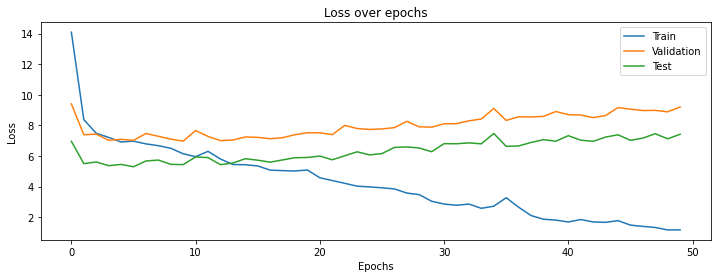

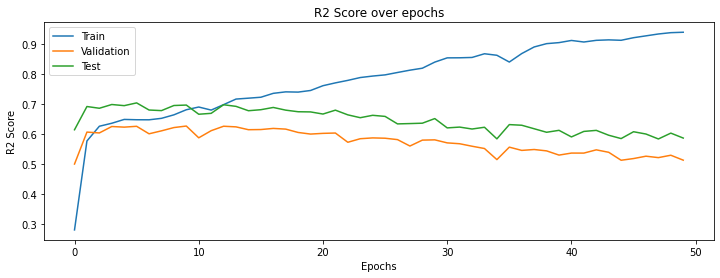

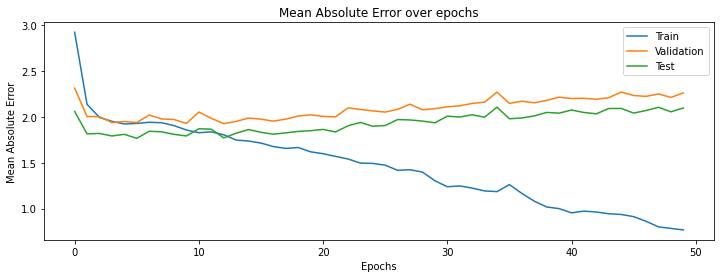

In [ ]:
# Plot losses
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot R2 scores
plt.figure(figsize=(12, 4))
plt.plot(train_r2_scores, label='Train')
plt.plot(val_r2_scores, label='Validation')
plt.plot(test_r2_scores, label='Test')
plt.title('R2 Score over epochs')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

# Plot MAEs
plt.figure(figsize=(12, 4))
plt.plot(train_maes, label='Train')
plt.plot(val_maes, label='Validation')
plt.plot(test_maes, label='Test')
plt.title('Mean Absolute Error over epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [ ]:
def test_example(idx):
    example = data_list_test[idx]
    print(f'Number of objects = {example.x.shape[0]}')
    pred = model(example)
    true = example.y
    print(f'Predicted = \n {pred},\n Ground-truth = \n {true}')

test_example(5)

Number of objects = 9
Predicted = 
 tensor([[-0.3890, -1.7734],
        [-3.8027,  4.1485],
        [ 0.0433, -5.2258],
        [ 3.9641,  0.3598],
        [-3.1195,  6.5067],
        [-0.4845, -3.7214],
        [ 5.8031,  1.4657],
        [-2.2144, -4.0112],
        [ 0.3719, -3.3808]], grad_fn=<AddBackward0>),
 Ground-truth = 
 tensor([[-1.6904, -4.7714],
        [-6.4399,  6.5713],
        [-2.6690, -3.6703],
        [ 7.4225,  4.6230],
        [-4.8910,  7.5831],
        [-2.7757, -4.8574],
        [ 6.9858,  6.4830],
        [ 6.2565,  0.0731],
        [-1.4717, -8.1335]])


# Task 2